# CNN to classify Cat and Dog

## Visualizing Models, Data, and Training with TensorBoard

* PyTorch integrates with T**ensorBoard**, a tool designed for visualizing the results of neural network training runs. 

* This tutorial illustrates some of its functionality, using the **Fashion-MNIST dataset** which can be read into PyTorch using torchvision.datasets.

# Outline

In this tutorial, we’ll learn how to:

* Read in data and with appropriate transforms (nearly identical to the prior tutorial).
 * Set up TensorBoard.
  * Write to TensorBoard.
   * Inspect a model architecture using TensorBoard.
   * Use TensorBoard to create interactive versions of the visualizations 

Specifically, on point #5, we’ll see:

        * A couple of ways to inspect our training data
        * How to track our model’s performance as it trains
        * How to assess our model’s performance once it is trained.


# Data contains
* The data contains dog and cat images
# Models
* We define a CNN with 4 convolution layers fully connected.


## Let's start by import some libraries

In [1]:
from plot_lib import plot_data, plot_model, set_default#

In [2]:
set_default()

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.image import imread
import os
import glob
import os.path as osp
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torch.utils import data as D


# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Define dataset customes

In [32]:
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory

In [33]:
image_size = (224, 224)
image_row_size = image_size[0] * image_size[1]
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.ToTensor()
                                ])
    


In [34]:
path    = 'Data/train'
data_train = CatDogDataset(path, transform=transform)


In [35]:
path1   = 'Data/test'
data_test = CatDogDataset(path1, transform=transform)


### Show images in data_train and data_test

In [36]:
def imshow(source):
    plt.figure(figsize=(10,10))
    imt = (source.view(-1, image_size[0], image_size[0]))
    imt = imt.numpy().transpose([1,2,0])
#     imt = (std * imt + mean).clip(0,1)
    plt.subplot(1,2,2)
    plt.imshow(imt)


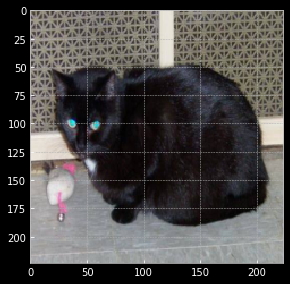

In [37]:
imshow(data_train[0][0])
#imshow(data_train[2][0])
#imshow(data_train[6000][0])

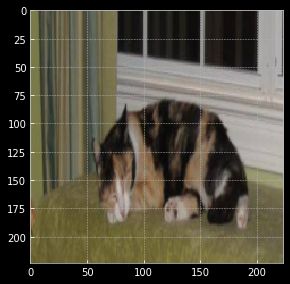

In [38]:
imshow(data_test[0][0])


## Create DataLoader

* We will precise the batch_size, num_workers, and if the data will be shuffle or not.

In [39]:
shuffle     = True
batch_size  = 64
num_workers = 0

dataloader_train  = DataLoader(dataset=data_train, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)


dataloader_test  = DataLoader(dataset=data_test, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)

In [40]:
#next(iter(data_train))

### Let's check the size of the input (images) and the label




In [41]:
torchimage =iter( dataloader_train )             #create a iterator from a train_loader object
images, labels = torchimage.next() 
print(images.size())                              #print the size of the batch

torch.Size([64, 3, 224, 224])


### Check classes and the size of the images

In [42]:
dataloader_train.dataset.classes

['cat', 'dog']

In [43]:
dataloader_train .dataset.__getitem__(0)[0].size()  #check the size of the image

torch.Size([3, 224, 224])

###  A function to show images with one channel

In [44]:
# constant for classes
classes = ('cat', 'dog')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2.0 + 0.5    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

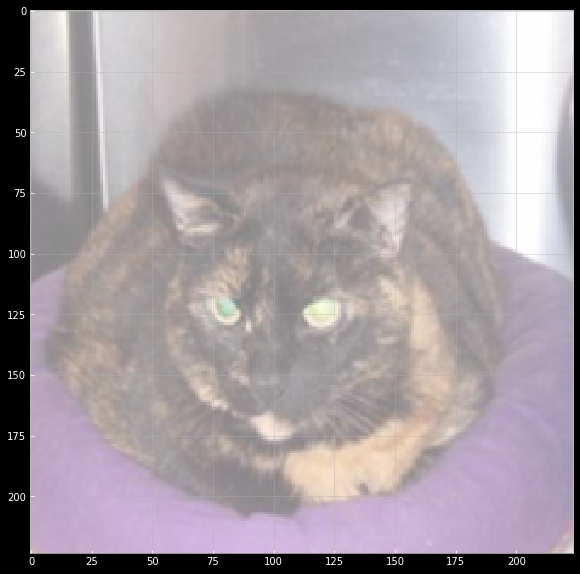

In [45]:
matplotlib_imshow(dataloader_train.dataset.__getitem__(4)[0], one_channel = False)

### A function to check the outpout shape and the filter size

In [46]:

import torch.nn as nn
n_feature = 3
check_archi = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(32, 64, kernel_size=5),
                            nn.MaxPool2d(2, 2),
                            nn.Conv2d(64, 128, kernel_size=5),
                            nn.MaxPool2d(2, 2))
                    

In [47]:
check_archi(torch.rand(1,3, 224,224)).shape[1]

128

In [48]:

filt, size = check_archi(torch.rand(20,3, 224, 224)).shape[1],\
        check_archi(torch.rand(20,3, 224, 224)).shape[2]
print(f'filter size {filt} and output shape {size}')

filter size 128 and output shape 24


# Build  model architecture

* We define a FC2Layer (Fully Connected Layer)
* A  CNN model(with 2 fully connected layer) where the output  is cat or dog

In [49]:
input_size  = 224*224*3   # images are 28x28 pixels
output_size = 2     # there are 2 classes
n_features = 6

In [62]:
class CNN_1(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=5)
        self.fc1 = nn.Linear(128*10*10, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 128*10*10) #(batch_size, -1) we can use also this
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

### Define the optimizer and criterion

In [63]:
model_CNN = CNN_1(input_size, n_features, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_CNN.parameters(), lr=0.01, momentum=0.5)

## 1. TensorBoard setup

We start  TensorBoard by importing **tensorboard** from **torch.utils** and defining a **SummaryWriter**, our key object for writing information to TensorBoard.

In [64]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cat_dog_experiment_1')

## 2. Writing to TensorBoard
 We can write an image to our TensorBoard - specifically, a grid - using **make_grid**

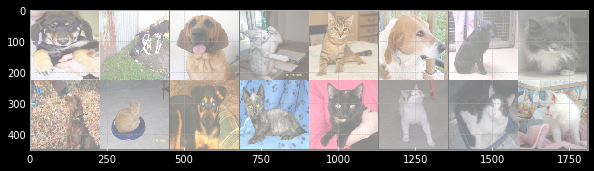

In [65]:
dataiter = iter(dataloader_train )
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[:16])

# show images
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('cat_dog_images', img_grid)

## 3. Inspect the model using TensorBoard

One of TensorBoard’s strengths is its ability to visualize complex model structures. **add_graph** help to visualize the model we built.

In [66]:
writer.add_graph(model_CNN, images)
writer.close()

/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## 4. Adding a 'Projector' tp TensorBoard

* We can visualize the lower dimensional representation of higher diimensional data via the **add_embedding** method.

* In the “Projector” tab of TensorBoard, you can see these 100 images - each of which is 784 dimensional - projected down into three dimensional space.

In [67]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# # select random images and their target indices
# images, labels = select_n_random(dataloader_train.data, dataloader_train.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 3 * 224 * 224)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

## 5.Tracking model training with TensorBoard

We will nstead log the running loss to TensorBoard, along with a view into the predictions the model is making via the plot_classes_preds function

In [68]:
# helper functions

def images_to_probs(model_CNN, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model_CNN(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model_CNN, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(model_CNN, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [69]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(dataloader_train, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0 and i>5:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(dataloader_train) + i)
            

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model_CNN, inputs, labels),
                            global_step=epoch * len(dataloader_train) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## 6. Assessing trained models with TensorBoard

In [58]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        output = model_CNN(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

It's better to run the code in the terminal **tensorboard --logdir=runs**  from the command line and then navigating to https://localhost:6006

Now we know how to use TensorBoard! This example, however, could be done in a Jupyter Notebook - where TensorBoard really excels is in creating interactive visualizations.

Thanks!
